LSTM!!!!!!

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import re
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [3]:
os.getcwd()
# from thon.Choose import choose_features
from thon.churn_functions import modernize, out_eval, bake, simple_split
#data = choose_features("data/out/features.csv", cv_range = (0, 30), save = False)

In [4]:
data = pd.read_csv("data/out/features.csv")
X, y = data.drop(columns = ['n']), data[['n']]

In [ ]:
# needs feature selection

In [5]:
ss = StandardScaler

X_scaler = ss().fit(X)
y_scaler = ss().fit(y)

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(X_ss, y_ss, test_size = .1, shuffle = False)
X_train, X_test, y_train, y_test = simple_split(X, y, 120)

In [282]:
X_train_tensors = Variable(torch.Tensor(X_scaler.transform(X_train)))
X_test_tensors = Variable(torch.Tensor(X_scaler.transform(X_test)))

y_train_tensors = Variable(torch.Tensor(y_scaler.transform(y_train)))
y_test_tensors = Variable(torch.Tensor(y_scaler.transform(y_test)))

tensor(0.4072)

In [283]:
#reshaping to rows, timestamps, features
# is this the right shape?
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [284]:
X_train_tensors_final

tensor([[[-1.8439, -2.2585, -1.5432,  ..., -0.6810,  0.8207, -1.6565]],

        [[-1.1968, -2.5231, -1.6419,  ..., -0.5012, -0.0489, -1.6565]],

        [[-0.3032, -1.8415, -1.5626,  ..., -0.4636,  1.7073, -1.6565]],

        ...,

        [[-0.5189,  0.6896, -0.4078,  ..., -0.2375, -1.0668,  1.1043]],

        [[-0.2416,  0.8161, -0.5961,  ...,  0.1484, -0.5192,  1.1043]],

        [[-0.1491,  0.7632, -0.5713,  ...,  0.2671, -0.8843,  1.1043]]])

In [76]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([120, 1, 74]) torch.Size([120, 1])
Testing Shape torch.Size([30, 1, 74]) torch.Size([30, 1])


In [77]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, proj_size = 3) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 32) #fully connected 1
        self.fc = nn.Linear(32, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [238]:
num_epochs = 100 #1000 epochs
learning_rate = 0.01 #0.001 lr

input_size = 74 #number of features
hidden_size = 12 #number of features in hidden state
num_layers = 1 #number of stacked layers

num_classes = 1 #number of output classes 

In [79]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

In [239]:
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        # Propagate input through LSTM
        output, hn = self.gru(x, h_0) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc(out) #first Dense
        return out

In [240]:
gru = GRUNet(input_size, hidden_size, num_classes, num_layers)

In [241]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate) 

In [259]:
for epoch in range(num_epochs):
    
    outputs = gru(X_train_tensors_final)

    optimizer.zero_grad()

    loss = criterion(outputs, y_train_tensors)

    loss.backward()

    optimizer.step()

    if epoch % (num_epochs//10) == 1:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 1, loss: 0.00197
Epoch: 11, loss: 0.00182
Epoch: 21, loss: 0.00183
Epoch: 31, loss: 0.00180
Epoch: 41, loss: 0.00178
Epoch: 51, loss: 0.00177
Epoch: 61, loss: 0.00176
Epoch: 71, loss: 0.00175
Epoch: 81, loss: 0.00174
Epoch: 91, loss: 0.00173


In [260]:
df_X_ss = X_scaler.transform(data.drop(columns = 'n')) #old transformers
df_y_mm = y_scaler.transform(data[['n']]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))

#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], df_X_ss.shape[1]))

In [90]:
df_X_ss.shape

torch.Size([150, 74])

In [261]:
with torch.no_grad():
    lstm1.eval()
    train_pred = gru(X_train_tensors_final)#forward pass
    
train_pred = train_pred.data.numpy() #numpy conversion
train_pred = y_scaler.inverse_transform(train_pred)
# plot_eval(y_train, train_pred)

In [262]:
# test prediction
with torch.no_grad():
    gru.eval()
    test_pred = gru(X_test_tensors_final)#forward pass
    
test_pred = test_pred.data.numpy() #numpy conversion
test_pred = y_scaler.inverse_transform(test_pred)

In [263]:
X_modern = modernize(X_train)
X_modern_tensors = Variable(torch.Tensor(X_scaler.transform(X_modern)))
X_modern_tensors_final = torch.reshape(X_modern_tensors, (X_modern_tensors.shape[0], 1, X_modern_tensors.shape[1]))

In [264]:
with torch.no_grad():
    gru.eval()
    pred = gru(X_modern_tensors_final)#forward pass

In [265]:
y_pred = y_scaler.inverse_transform(pred)
y_pred

array([[345.82810308],
       [307.09483594],
       [312.03810405]])

In [266]:
out2 = out[out['group'] != 'test']

In [267]:
t2 = out[out['group'] == 'test']
t2[['pred']] = t2[['pred']].shift(-3)

C:\Users\keato\AppData\Local\Temp\ipykernel_1524\3469323894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2[['pred']] = t2[['pred']].shift(-3)


In [268]:
oo = pd.concat([out2, t2], axis= 0)
oo.drop([147, 148, 149], axis = 0, inplace = True)

In [269]:
out = bake(y_train.squeeze(), y_test.squeeze(), train_pred.squeeze(), test_pred.squeeze(), y_pred.squeeze())

7.9114970815076955 5757.127648026838


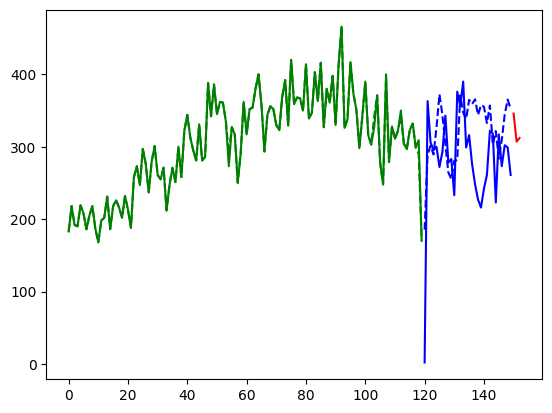

In [270]:
import sklearn
out_eval(out, sklearn.metrics.mean_squared_error)

In [271]:
from thon.models import lasso
features = lasso.lasso_vars(scoring = "neg_mean_squared_error",
               split = 120)

In [2]:
from thon.models import lstm
from sklearn.preprocessing import MinMaxScaler

out = lstm.run_lstm(split = 132,
             num_epochs = 1000,
             learning_rate = 0.001,
             feature_selection = features,
             data_dir = "data/out/features.csv",
             targetvar = 'n')

Epoch: 0, loss: 0.16898
Epoch: 100, loss: 0.01025
Epoch: 200, loss: 0.00805
Epoch: 300, loss: 0.00577
Epoch: 400, loss: 0.00482
Epoch: 500, loss: 0.00437
Epoch: 600, loss: 0.00409
Epoch: 700, loss: 0.00392
Epoch: 800, loss: 0.00377
Epoch: 900, loss: 0.00365


In [3]:
def out_eval(data, metric):
    
    # split data
    train = data[data['group'] == 'train']
    test = data[data['group'] == 'test']
    pred = data[data['group'] == 'pred']
    
    train_metric = metric(train['pred'], train['actual'])
    test_metric = metric(test['pred'], test['actual'])

    
    plt.plot(train['actual'], 'g')
    plt.plot(train['pred'], 'g--')
    plt.plot(test['actual'], 'b')
    plt.plot(test['pred'], 'b--')
    plt.plot(pred['pred'], 'r')    
    return(train_metric, test_metric)

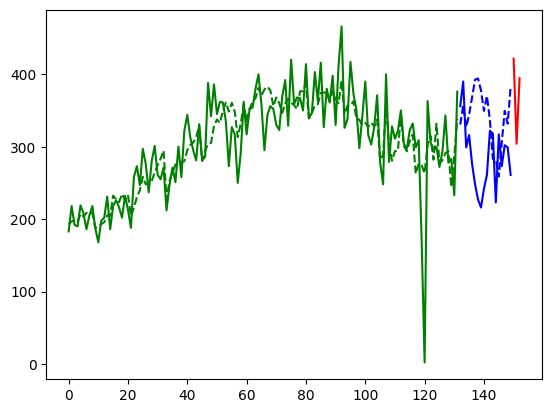

In [4]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
out_eval(out, metrics.mean_squared_error)

In [272]:
train_met = []
test_met = []

for e in range(100, 2000, 200):
    out = lstm.run_lstm(split = 108,
             num_epochs = e,
             learning_rate = 0.005,
             feature_selection = features,
             data_dir = "data/out/features.csv",
             targetvar = 'n')
    a = out_eval(out, metrics.mean_squared_error)
    
    train_met.append(a[0])
    test_met.append(a[1])

NameError: name 'lstm' is not defined

In [300]:
X_train_tensors_final.index

AttributeError: 'Tensor' object has no attribute 'index'

In [297]:
from captum.attr import FeaturePermutation
feature_perm = FeaturePermutation(gru.eval())
attr = feature_perm.attribute(X_train_tensors_final, target=y_train_tensors.squeeze())

RuntimeError: gather(): Expected dtype int64 for index

In [118]:
# permutation feature imp
from sklearn.inspection import permutation_importance
r = permutation_importance(lstm1.eval(), X_train_tensors_final, y_train_tensors,
                           scoring = criterion,
                        n_repeats=30,
                        random_state=1933)

ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
 if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
     print(f"{diabetes.feature_names[i]:<8}"
           f"{r.importances_mean[i]:.3f}"
           f" +/- {r.importances_std[i]:.3f}")# 500 epochs is best when only using FEATURES